# Abnormalities

## Looking at rate of change..

In [62]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow 

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard
from sklearn import metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import common

env: KERAS_BACKEND=tensorflow


In [65]:
df = common.load_df("../data/insead", "*.csv")
print(common.load_df.cache_info())

features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
target = ["cwshdr"]

cols = features + target
df = common.Process.replace_nulls(df, cols=cols)
df = common.Process.replace_with_near(df, cols=cols)
df = common.Process.smooth_data(df, cols=cols)
df = common.Process.get_normalized_df(df, cols=cols)

# create features
df["hour"] = df.index.hour

# take train and test data.. 
train = df["2016-01-01":"2016-01-15"]
test = df["2016-01-16":"2016-01-16"]

CacheInfo(hits=8, misses=1, maxsize=None, currsize=1)


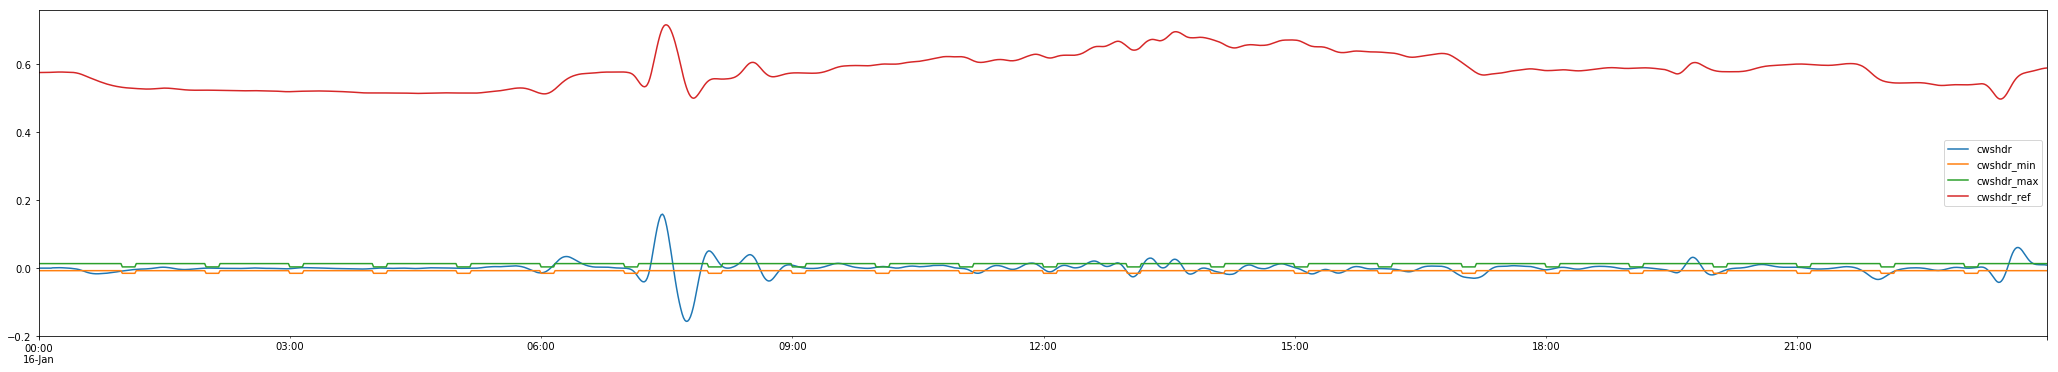

In [6]:
# rate of change.
first_order_diff = lambda x, delta: (x - x.shift(delta)).fillna(0)
train_rate = first_order_diff(train, delta=10)
test_rate = first_order_diff(test, delta=10)

# Assuming 1hr bins. group data.
min_per_hr = train_rate.groupby(["hour"]).quantile(.1)
max_per_hr = test_rate.groupby(["hour"]).quantile(.9)

# set columns with bin values.
test_rate["cwshdr_min"] = test_rate.hour.apply(lambda x: min_per_hr.cwshdr.iloc[int(x)])
test_rate["cwshdr_max"] = test_rate.hour.apply(lambda x: max_per_hr.cwshdr.iloc[int(x)])

# normalized
test_rate["cwshdr_ref"] = test["cwshdr"]

# # plot.
fig, ax = plt.subplots(1,1,figsize=(36,6))
test_rate[["cwshdr", "cwshdr_min", "cwshdr_max", "cwshdr_ref"]].plot(ax=ax)

Again, the hypothesis isn't solid... huuhhhh!!!!

## Comparing prediction vs. actual

Assuming the `model` correctly represents the physical properties of the system, its values could be taken as benchmark to analyze actual values. If the actual values are deviating too much from the model values, we could consider them as anomalies/abnormalities.

Note: the assumption is quite a stretch at this moment, with 6% MAPE.

In [60]:
model = load_model("../output/cwshdr2.h5")

MSE:  0.00165479892559
MAPE:  5.87521913965


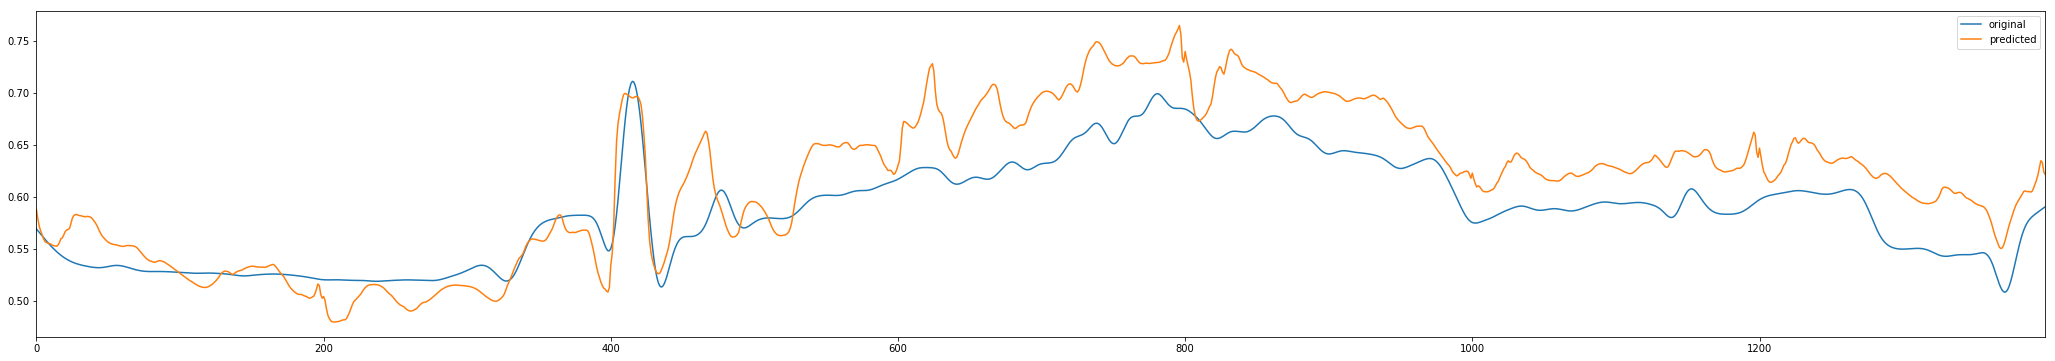

In [67]:
test_x, test_y = common.prepare_keras_data(test, features, target, 15, 200) # prepare keras features
predicted_y = model.predict(test_x, batch_size=200) # predict

predicted_y = common.Reshape.inv_y(predicted_y) # reshape prediction
test_y = common.Reshape.inv_y(test_y) # reshape target

print("MSE: ", metrics.mean_squared_error(test_y, predicted_y))
print("MAPE: ", common.mean_absolute_percent_error(test_y, predicted_y))

plot_df = pd.DataFrame({
    "original": common.Reshape.inv_y(test_y),
    "predicted": common.Reshape.inv_y(predicted_y)
})
ax = plot_df.plot(figsize=(36,6))